# Visualize and Analyze Data

This notebook will explore the data we downloaded in the `Customize and Access Data` notebook to fulfill the final objective of this tutorial: 

* Interact with ICESat-2 and MODIS data using basic Python science libraries to visualize, filter, and plot concurrent data.

We will perform the following steps:

1. Read in ATL07 and ATL10 data and apply time conversion
3. Read in MOD29 data and apply scale factor 
4. Overlay ATL07 data over MOD29
5. Extract MOD29 Ice Surface Temperature (IST) values along ATL07 height values
6. Plot MOD29 IST and ATL07 heights
7. Plot ATL07 and ATL10 and compare ATL10 coverage with ATL07 quality variables
   

### Import packages

In [1]:
from collections import defaultdict
import h5py
import xarray as xr
import pyproj
import pandas as pd
import pyresample as prs
from matplotlib import pyplot as plt
import numpy as np
# to make sure we find the shell from ! cells
import os
os.environ["PATH"] += os.pathsep + os.pathsep.join(['/bin', '/bin/bash'])

# Helper functions
import tutorial_helper_functions as fn

#Allows plots to be rendered in notebook
%matplotlib inline

We will pull the rest of our data from a staged directory. This will only be available during the in-person tutorial. 

In [2]:
!aws --no-sign-request --region=us-west-2 s3 sync s3://nsidc-agu-tutorial-data/ Outputs

## Read in ATL07 and ATL10 and apply time conversion

We will be focusing on two packages to read in our data:

* [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/getting_started/overview.html)
    * Pandas is built on top of NumPy and provides easy to work with data structures. The pandas dataframe is a 2-D tabular data structure with labeled axes. 
* [Xarray](http://xarray.pydata.org/en/stable/index.html)
    * Designed for multidimensional data. Xarray introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays. 

### Load ATL07 and ATL10 granules into dataframes

We will start by defining variables to extract and combine as a single dataframe:

In [3]:
VARIABLES = {
    'ATL07': [
        '/gt1l/sea_ice_segments/delta_time',
        '/gt1l/sea_ice_segments/latitude',
        '/gt1l/sea_ice_segments/longitude',
        '/gt1l/sea_ice_segments/heights/height_segment_confidence',
        '/gt1l/sea_ice_segments/heights/height_segment_height',
        '/gt1l/sea_ice_segments/heights/height_segment_quality',
        '/gt1l/sea_ice_segments/heights/height_segment_surface_error_est',
        '/gt1l/sea_ice_segments/heights/height_segment_length_seg',
        '/gt2l/sea_ice_segments/delta_time',
        '/gt2l/sea_ice_segments/latitude',
        '/gt2l/sea_ice_segments/longitude',
        '/gt2l/sea_ice_segments/heights/height_segment_confidence',
        '/gt2l/sea_ice_segments/heights/height_segment_height',
        '/gt2l/sea_ice_segments/heights/height_segment_quality',
        '/gt2l/sea_ice_segments/heights/height_segment_surface_error_est',
        '/gt2l/sea_ice_segments/heights/height_segment_length_seg',
        '/gt3l/sea_ice_segments/delta_time',
        '/gt3l/sea_ice_segments/latitude',
        '/gt3l/sea_ice_segments/longitude',
        '/gt3l/sea_ice_segments/heights/height_segment_confidence',
        '/gt3l/sea_ice_segments/heights/height_segment_height',
        '/gt3l/sea_ice_segments/heights/height_segment_quality',
        '/gt3l/sea_ice_segments/heights/height_segment_surface_error_est',
        '/gt3l/sea_ice_segments/heights/height_segment_length_seg'],
    'ATL10': [
        '/gt1l/freeboard_beam_segment/beam_freeboard/delta_time',
        '/gt1l/freeboard_beam_segment/beam_freeboard/latitude',
        '/gt1l/freeboard_beam_segment/beam_freeboard/longitude',
        '/gt1l/freeboard_beam_segment/beam_freeboard/beam_fb_confidence',
        '/gt1l/freeboard_beam_segment/beam_freeboard/beam_fb_quality_flag',
        '/gt1l/freeboard_beam_segment/beam_freeboard/beam_fb_height',
        '/gt2l/freeboard_beam_segment/beam_freeboard/delta_time',
        '/gt2l/freeboard_beam_segment/beam_freeboard/latitude',
        '/gt2l/freeboard_beam_segment/beam_freeboard/longitude',
        '/gt2l/freeboard_beam_segment/beam_freeboard/beam_fb_confidence',
        '/gt2l/freeboard_beam_segment/beam_freeboard/beam_fb_quality_flag',
        '/gt2l/freeboard_beam_segment/beam_freeboard/beam_fb_height',
        '/gt3l/freeboard_beam_segment/beam_freeboard/delta_time',
        '/gt3l/freeboard_beam_segment/beam_freeboard/latitude',
        '/gt3l/freeboard_beam_segment/beam_freeboard/longitude',
        '/gt3l/freeboard_beam_segment/beam_freeboard/beam_fb_confidence',
        '/gt3l/freeboard_beam_segment/beam_freeboard/beam_fb_quality_flag',
        '/gt3l/freeboard_beam_segment/beam_freeboard/beam_fb_height'
    ]
}

#### We will use the `load_icesat2_as_dataframe` function from our functions module to load points from our ATL07 and ATL10 files: 

In [4]:
# Load ATL07 files
atl07_1298 = fn.load_icesat2_as_dataframe('./Outputs/processed_ATL07-01_20190323101341_12980201_002_01.h5', VARIABLES)
atl07_1305 = fn.load_icesat2_as_dataframe('./Outputs/processed_ATL07-01_20190323211343_13050201_002_01.h5', VARIABLES)
atl07 = pd.concat([atl07_1298,atl07_1305]) #concatenate dataframes to use in plot below

# Load single ATL10 file to compare with ATL07
atl10_1305 = fn.load_icesat2_as_dataframe('./Outputs/processed_ATL10-01_20190323211343_13050201_002_01.h5', VARIABLES)

atl07_1298.head() # Print head of dataframe 

,beam,delta_time,height_segment_confidence,height_segment_height,height_segment_length_seg,height_segment_quality,height_segment_surface_error_est,latitude,longitude,filename
0,gt1l,3.857279e+07,0.012045,0.043003,9.379528,1,0.018945,79.999982,152.232054,processed_ATL07-01_20190323101341_12980201_002...
1,gt1l,3.857279e+07,0.015299,0.026843,9.371373,1,0.019077,79.999946,152.231994,processed_ATL07-01_20190323101341_12980201_002...
2,gt1l,3.857279e+07,0.013423,0.072230,10.736919,1,0.019572,79.999898,152.231911,processed_ATL07-01_20190323101341_12980201_002...
3,gt1l,3.857279e+07,0.011518,0.034719,10.744951,1,0.018614,79.999850,152.231830,processed_ATL07-01_20190323101341_12980201_002...
4,gt1l,3.857279e+07,0.010973,0.018861,10.782303,1,0.019800,79.999806,152.231756,processed_ATL07-01_20190323101341_12980201_002...


### Convert ATL07 'delta_time' to utc datetime values

In [5]:
data_granules = [atl07_1298, atl07_1305, atl10_1305] # Create list of each dataframe

for df in data_granules:
    df['utc_datetime'] = df['delta_time'].apply(fn.convert_delta_time)
    df = df.sort_values(by=['beam', 'utc_datetime'])

data_granules[0].head() # View the head of the first dataframe in list: atl07_1298

,beam,delta_time,height_segment_confidence,height_segment_height,height_segment_length_seg,height_segment_quality,height_segment_surface_error_est,latitude,longitude,filename,utc_datetime
0,gt1l,3.857279e+07,0.012045,0.043003,9.379528,1,0.018945,79.999982,152.232054,processed_ATL07-01_20190323101341_12980201_002...,2019-03-23 10:39:50.835434
1,gt1l,3.857279e+07,0.015299,0.026843,9.371373,1,0.019077,79.999946,152.231994,processed_ATL07-01_20190323101341_12980201_002...,2019-03-23 10:39:50.836040
2,gt1l,3.857279e+07,0.013423,0.072230,10.736919,1,0.019572,79.999898,152.231911,processed_ATL07-01_20190323101341_12980201_002...,2019-03-23 10:39:50.836879
3,gt1l,3.857279e+07,0.011518,0.034719,10.744951,1,0.018614,79.999850,152.231830,processed_ATL07-01_20190323101341_12980201_002...,2019-03-23 10:39:50.837701
4,gt1l,3.857279e+07,0.010973,0.018861,10.782303,1,0.019800,79.999806,152.231756,processed_ATL07-01_20190323101341_12980201_002...,2019-03-23 10:39:50.838461


## Read in MODIS Ice Surface Temperature file and apply scale factor

There were 13 granules returned over our time and area of interest. We can use Earthdata Search to easily visualize the coverage of each granule:
[MODIS Earthdata Search result](https://search.earthdata.nasa.gov/search/granules?p=C1000001160-NSIDC_ECS&q=mod29&sb=140%2C72%2C153%2C80&m=80.14349326047419!-42.27686414753069!0!0!0!0%2C2&qt=2019-03-23T00%3A00%3A00.000Z%2C2019-03-23T23%3A59%3A59.999Z&tl=1557787959!4!)

Let's choose a single MODIS granule to be used in our analysis below. 

Out of the 13 returned, these all have full coverage over our study area:

* MOD29.A2019082.0810.006.2019082191746.hdf
* MOD29.A2019082.0630.006.2019082191633.hdf
* MOD29.A2019082.0455.006.2019082132032.hdf
* MOD29.A2019082.0945.006.2019082191513.hdf

And after viewing the browse images, this looks to have the best data coverage:

* MOD29.A2019082.0140.006.2019082132036.hdf


### Load the MOD29 file into xarray and list variables of file

In [6]:
filepath = './Outputs/MOD29_A2019082_0140_006_2019082132036_HEGOUT.hdf' # Define local filepath 

mod29 = xr.open_dataset(filepath)
list(mod29.variables)

['Latitude',
 'Longitude',
 'Sea_Ice_by_Reflectance',
 'Sea_Ice_by_Reflectance_Pixel_QA',
 'Ice_Surface_Temperature',
 'Ice_Surface_Temperature_Pixel_QA']

### Convert calibrated data to Kelvin

Before we plot the ATL07 heights over MODIS IST, we need to convert the Ice_Surface_Temperature values to kelvin. According to the [MOD29 User Guide](https://nsidc.org/data/mod29#title11) the Ice_Surface_Temperature (IST) values are stored as calibrated data. To convert to kelvin, use scale_factor = 0.01 and add_offset = 0.0 in the following equation:

IST = scale_factor × (calibrated data - add_offset)

The valid range for ISTs is 210 K to 313.20 K.

Let's apply this conversion to our xarray:

In [7]:
mod29['Ice_Surface_Temperature'] = mod29['Ice_Surface_Temperature']*(0.01) # Apply calibrated data to kelvin conversion

## Visualize ICESat-2 height values over MODIS Ice Surface Temperature

We can visualize the ICESat-2 track locations and height values overlayed with MODIS Ice Surface Temperature. We should see higher ATL07 heights along fast ice, with lower heights over thin ice and then increasing height over drift ice. We are using the Matplotlib `pcolormesh` function to plot our MOD29 xarray as a 2D array. The ATL07 locations are plotted as a scatter plot. 

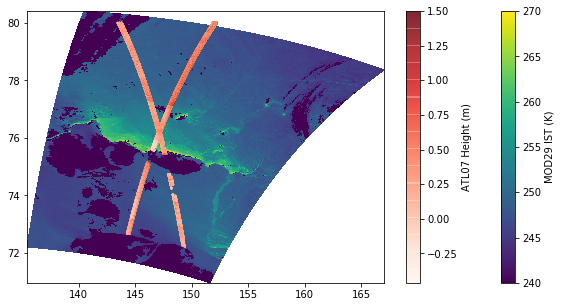

In [8]:
plt.subplots(figsize=(10,5)) # set size
plt.pcolormesh(mod29.Longitude, mod29.Latitude, mod29.Ice_Surface_Temperature, vmin=240, vmax=270, cmap='viridis') # Set range to valid IST values
plt.colorbar(label='MOD29 IST (K)')
plt.scatter(atl07.longitude, atl07.latitude,
          c=atl07.height_segment_height, vmax=1.5,
          cmap='Reds', alpha=0.6, s=1)    
plt.colorbar(label='ATL07 Height (m)')
plt.show()

## Extract MODIS IST values along the ICESat-2 tracks

Now that we've visually inspected height and IST values, let's do some analysis. We will now extract MODIS IST values at each ATL07 point. We'll focus on the 1305 track from here on out. 

### Interpolating MOD29 onto ICESat-2 points

To easily interpolate MOD29 to ICESat-2 points, we can use the `pyresample` library. The `radius_of_influence` parameter determines maximum radius to look for nearest neighbor interpolation.

In [9]:
# Define lat lon swath geometry used for interpolation
icesat2_geometry_atl07_1305 = prs.geometry.SwathDefinition(lons=atl07_1305['longitude'], lats=atl07_1305['latitude'])
icesat2_geometry_atl10_1305 = prs.geometry.SwathDefinition(lons=atl10_1305['longitude'], lats=atl10_1305['latitude'])
mod29_geometry = prs.geometry.SwathDefinition(lons=mod29['Longitude'], lats=mod29['Latitude'])

# Add IST values to each pandas dataframe
atl07_1305['mod29_ice_surface_temperature'] = prs.kd_tree.resample_nearest(mod29_geometry, mod29['Ice_Surface_Temperature'].values, icesat2_geometry_atl07_1305, radius_of_influence=1000, fill_value=np.nan)
atl10_1305['mod29_ice_surface_temperature'] = prs.kd_tree.resample_nearest(mod29_geometry, mod29['Ice_Surface_Temperature'].values, icesat2_geometry_atl10_1305, radius_of_influence=1000, fill_value=np.nan)

We can now apply nan's to the MOD29 land mask value:

In [10]:
atl07_1305[atl07_1305['mod29_ice_surface_temperature'] == 50] = np.nan
atl10_1305[atl10_1305['mod29_ice_surface_temperature'] == 50] = np.nan
atl07_1305.head()

,beam,delta_time,height_segment_confidence,height_segment_height,height_segment_length_seg,height_segment_quality,height_segment_surface_error_est,latitude,longitude,filename,utc_datetime,mod29_ice_surface_temperature
0,gt1l,3.861196e+07,NaN,NaN,5322.696777,0.0,NaN,72.248712,149.196411,processed_ATL07-01_20190323211343_13050201_002...,2019-03-23 21:32:36.515469,246.939987
1,gt1l,3.861196e+07,NaN,NaN,2662.693604,0.0,NaN,72.248712,149.196411,processed_ATL07-01_20190323211343_13050201_002...,2019-03-23 21:32:36.515469,246.939987
2,gt1l,3.861196e+07,NaN,NaN,1332.524902,0.0,NaN,72.248712,149.196411,processed_ATL07-01_20190323211343_13050201_002...,2019-03-23 21:32:36.515469,246.939987
3,gt1l,3.861196e+07,NaN,NaN,666.213989,0.0,NaN,72.248712,149.196411,processed_ATL07-01_20190323211343_13050201_002...,2019-03-23 21:32:36.515469,246.939987
4,gt1l,3.861196e+07,NaN,NaN,334.582428,0.0,NaN,72.248712,149.196411,processed_ATL07-01_20190323211343_13050201_002...,2019-03-23 21:32:36.515469,246.939987


## Plot MODIS IST and ICESat-2 height along tracks

We will use pandas plotting which utilizes matplotlib on the backend. The pandas `loc` attribute allows access to a group of rows or columns by label.

The 1305 track is moving from low to high latitude: The start time begins at the fast ice, skips over an island, and moves towards warmer thin ice onto thicker drift ice. 

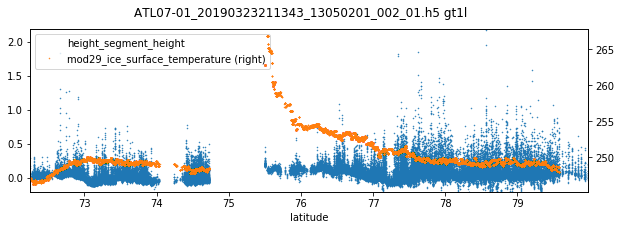

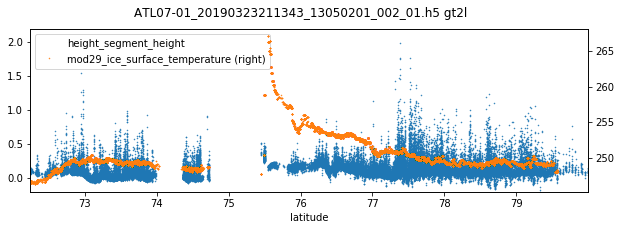

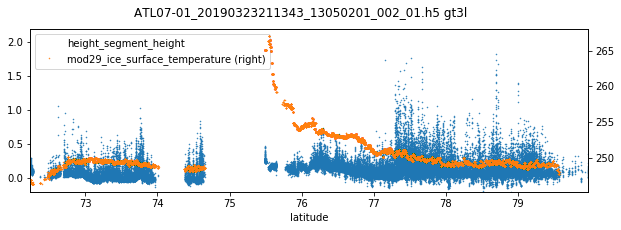

In [11]:
# gt1l
fig, ax = plt.subplots(figsize=(10,3))
atl07_1305.loc[atl07_1305['beam'] == 'gt1l'].plot(x='latitude', y='height_segment_height', marker='.', markersize=1, linestyle='None', ax=ax)
atl07_1305.loc[atl07_1305['beam'] == 'gt1l'].plot(x='latitude', y='mod29_ice_surface_temperature', marker='.', markersize=1, linestyle='None', ax=ax, secondary_y=True)
fig.suptitle('ATL07-01_20190323211343_13050201_002_01.h5 gt1l')
ax.set_ylim(-0.2,2.2)

# gt2l
fig, ax = plt.subplots(figsize=(10,3))
atl07_1305.loc[atl07_1305['beam'] == 'gt2l'].plot(x='latitude', y='height_segment_height', marker='.', markersize=1, linestyle='None', ax=ax)
atl07_1305.loc[atl07_1305['beam'] == 'gt2l'].plot(x='latitude', y='mod29_ice_surface_temperature', marker='.', markersize=1, linestyle='None', ax=ax, secondary_y=True)
fig.suptitle('ATL07-01_20190323211343_13050201_002_01.h5 gt2l')
ax.set_ylim(-0.2,2.2)

# gt3l 
fig, ax = plt.subplots(figsize=(10,3))
atl07_1305.loc[atl07_1305['beam'] == 'gt3l'].plot(x='latitude', y='height_segment_height', marker='.', markersize=1, linestyle='None', ax=ax)
atl07_1305.loc[atl07_1305['beam'] == 'gt3l'].plot(x='latitude', y='mod29_ice_surface_temperature', marker='.', markersize=1, linestyle='None', ax=ax, secondary_y=True)
fig.suptitle('ATL07-01_20190323211343_13050201_002_01.h5 gt3l')
ax.set_ylim(-0.2,2.2);

Key observations:

* Over fast ice (lower latitude), cold IST with fairly constant and higher ICESat-2 heights.
* Warm IST is seen in open water, with thin ice just off the fast ice boundary.
* As the drift ice thickens, the height is increasing as IST decreases.

___ 
### ***On your own***: Plot ATL10 against ATL07 for a single beam. How does the coverage compare between the two?

Hint: Copy the 5 lines of code for one of the ATL07 and MOD29 single beam plots above. Do not change the first ATL07 `height_segment_height` plot line. Replace the following items on the second `mod29_ice_surface_temperature` plot line:
   1. Replace the `atl07_1305` dataframe with `atl10_1305`
   2. Replace `mod29_ice_surface_temperature` with `beam_fb_height` as the y values


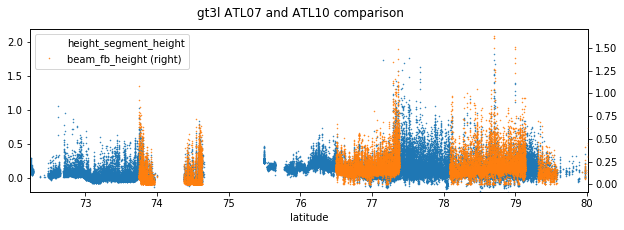

In [12]:
# Answer below!

# gt3l 
fig, ax = plt.subplots(figsize=(10,3))
atl07_1305.loc[atl07_1305['beam'] == 'gt3l'].plot(x='latitude', y='height_segment_height', marker='.', markersize=1, linestyle='None', ax=ax)
atl10_1305.loc[atl10_1305['beam'] == 'gt3l'].plot(x='latitude', y='beam_fb_height', marker='.', markersize=1, linestyle='None', ax=ax, secondary_y=True)
fig.suptitle('gt3l ATL07 and ATL10 comparison')
ax.set_ylim(-0.2,2.2);


## Data filtering by quality flag

How do the ATL07 quality parameters relate to ATL10 coverage? We should see more ATL10 values with better ATL07 quality and visa versa.

The following plots show some examples of these quality flags and error estimates. You can modify plotting variable below to compare with other quality information. 

We will filter `height_segment_height` based on `height_segment_quality` and plot the error estimates. According to the [User Guide](https://nsidc.org/data/ATL07#title38):

For ATL07 height_segment_quality: a binary indicator (1 = good, 0 = bad) of segment quality

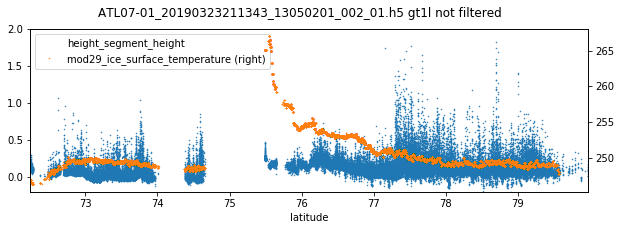

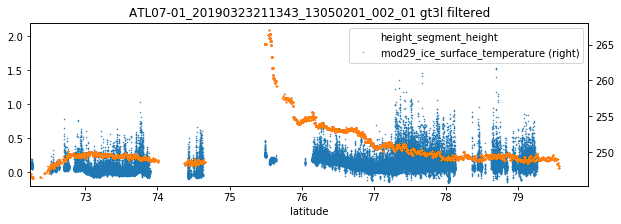

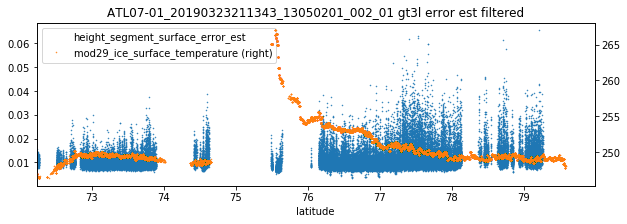

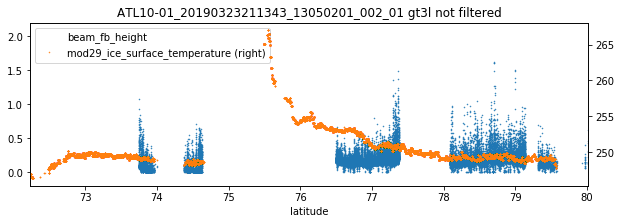

In [13]:
# Available variables to plot for ATL07: 

# height_segment_height
# height_segment_confidence 
# height_segment_quality
# height_segment_surface_error_est
# height_segment_length_seg

# First Create a condition dictionary with the variables we wish to filter against. Here we want to only show the gt31 beam and good quality (quality = 1)
cond = {
    'beam': 'gt3l', 
    'height_segment_quality': 1
}


# Unfiltered ATL07 heights
fig, ax = plt.subplots(figsize=(10,3))
atl07_1305.loc[(atl07_1305.beam == cond['beam'])].plot(x='latitude', y='height_segment_height', marker='.', markersize=1, linestyle='None', ax=ax)
atl07_1305.loc[(atl07_1305.beam == cond['beam'])].plot(x='latitude', y='mod29_ice_surface_temperature', marker='.', markersize=1, linestyle='None', ax=ax, secondary_y=True)
fig.suptitle('ATL07-01_20190323211343_13050201_002_01.h5 gt1l not filtered')
ax.set_ylim(-0.2,2);

# Filtered ATL07 heights by height_segment_quality

# Create list with the variables we wish to filter against
atl07_cond = (atl07_1305.beam == cond['beam']) & (atl07_1305.height_segment_quality == cond['height_segment_quality'])

fig, ax = plt.subplots(figsize=(10,3))
atl07_1305.loc[atl07_cond].plot(x='latitude', y='height_segment_height', marker='.', markersize=1, linestyle='None', ax=ax) # plot quality and beam condition
atl07_1305.loc[(atl07_1305.beam == cond['beam'])].plot(x='latitude', y='mod29_ice_surface_temperature', marker='.', markersize=1, linestyle='None', ax=ax, secondary_y=True)
plt.title('ATL07-01_20190323211343_13050201_002_01 gt3l filtered')
ax.set_ylim(-0.2,2.2);

# Filtered by quality flag and plot height estimate
atl07_plot_var = 'height_segment_surface_error_est' # set a plot variable that can be easily modified

fig, ax = plt.subplots(figsize=(10,3))
atl07_1305.loc[atl07_cond].plot(x='latitude', y=atl07_plot_var, marker='.', markersize=1, linestyle='None', ax=ax)
atl07_1305.loc[(atl07_1305.beam == cond['beam'])].plot(x='latitude', y='mod29_ice_surface_temperature', marker='.', markersize=1, linestyle='None', ax=ax, secondary_y=True)
plt.title('ATL07-01_20190323211343_13050201_002_01 gt3l error est filtered');

# Plot unfiltered ATL10 heights for comparison
fig, ax = plt.subplots(figsize=(10,3))
atl10_1305.loc[atl10_1305.beam == cond['beam']].plot(x='latitude', y='beam_fb_height', marker='.', markersize=1, linestyle='None', ax=ax)
atl10_1305.loc[(atl10_1305.beam == cond['beam'])].plot(x='latitude', y='mod29_ice_surface_temperature', marker='.', markersize=1, linestyle='None', ax=ax, secondary_y=True)
plt.title('ATL10-01_20190323211343_13050201_002_01 gt3l not filtered')
ax.set_ylim(-0.2,2.2);

What do we see above?

* Height values with higher IST are getting filtered out. This is consistent with areas of more open water.
* We can use IST to find thin ice freeboard where there is ATL07 data but no ATL10 data.  

What else can you determine by plotting the other quality flags?